## Customizing the pipeline

### Reading the corpus

The Corpus class that represents the feature matrix which is the starting point for the analysis basically is a data frame that maps combinations of documents and features to feature counts. When _building_ the representation, it uses two helper classes to decouple aspects that are relevant for building the feature matrix: FeatureGenerator performs the actual reading and feature counting, DocumentDescriber provides labels and groupings for the documents that can be used in visualization and evaluation steps.

When you just create a corpus using `delta.Corpus(directory)`, default versions will be used, but stuff can be customized:

In [1]:
import delta
from matplotlib import pyplot as plt
help(delta.Corpus.__init__)

Help on function __init__ in module delta.corpus:

__init__(self, _source=None, /, *, subdir=None, file=None, corpus=None, feature_generator=None, document_describer=<delta.util.DefaultDocumentDescriber object at 0x7f0cc05b7670>, metadata=None, **kwargs)
    Creates a new Corpus.
    
    Args:
        subdir (str): Path to a subdirectory containing the (unprocessed) corpus data.
        file (str): Path to a CSV file containing the feature vectors.
        corpus (pandas.DataFrame): A dataframe or :class:`Corpus` from which to create a new corpus, as a copy.
        feature_generator (FeatureGenerator): A customizeable helper class that will process a `subdir` to a feature matrix, if the `subdir` argument is also given. If None, a default feature generator will be used.
        metadata (dict): A dictionary with metadata to copy into the new corpus.
        **kwargs: Additionally, if feature_generator is None and subdir is not None, you can pass FeatureGenerator
            arguments 

E.g., to create a corpus that ignores case differences and reads only the first 5000 tokens of each text (`lower_case` and `max_tokens` are arguments to the default FeatureGenerator):

In [2]:
corpus = delta.Corpus('../../refcor/English', lower_case=True, max_tokens=5000)
corpus.iloc[:5,100:110]

,say,sir,how,its,house,way,after,father,long,mother
ward_ashe,6.0,2.0,10.0,4.0,8.0,5.0,6.0,4.0,3.0,17.0
blackmore_springhaven,2.0,1.0,7.0,12.0,3.0,7.0,5.0,5.0,9.0,2.0
stevenson_island,5.0,4.0,4.0,0.0,7.0,10.0,5.0,12.0,5.0,5.0
thackeray_esmond,8.0,3.0,10.0,3.0,9.0,2.0,17.0,14.0,5.0,13.0
ward_milly,4.0,1.0,14.0,5.0,8.0,11.0,5.0,15.0,12.0,48.0


It is also possible to roll your own feature generator. As an example, we would like to use lemmas instead of word forms as features. For that, we would like to read a version of our corpus that has been preprocessed using the DARIAH DKPro wrapper.

A file like this is essentially a table that contains a line per token with various analyses in the columns:

In [3]:
import pandas as pd
import csv
dof_example = pd.read_table('../../refcor/dof/German/Huber,-Therese_Luise.txt.csv', quoting=csv.QUOTE_NONE, sep='\t')
dof_example.iloc[1003:10010]

,SectionId,ParagraphId,SentenceId,TokenId,Begin,End,Token,Lemma,CPOS,POS,...,Morphology,Hyphenation,DependencyHead,DependencyRelation,NamedEntity,QuoteMarker,CoreferenceChainIds,SyntaxTree,Predicate,SemanticArgumentIndex
1003,_,8,24,1003,5826,5836,Thatsachen,Thatsachen,NN,NN,...,_,That-sa-chen,1002,NK,_,0,_,_,_,_
1004,_,8,24,1004,5837,5844,annimmt,annehmen,V,VVFIN,...,_,an-nimmt,991,CJ,_,0,_,_,_,_
1005,_,8,24,1005,5844,5845,",",",",PUNC,"$,",...,_,",",1004,--,_,0,_,_,_,_
1006,_,8,24,1006,5846,5848,so,so,ADV,ADV,...,_,so,1007,MO,_,0,_,_,_,_
1007,_,8,24,1007,5849,5853,wird,werden,V,VAFIN,...,_,wird,-1,--,_,0,_,_,_,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10005,_,26,312,10005,55649,55650,;,;,PUNC,$.,...,_,;,10004,--,_,0,_,_,_,_
10006,_,26,312,10006,55651,55654,sie,sie,PR,PPER,...,_,sie,10007,SB,_,0,_,_,_,_
10007,_,26,312,10007,55655,55660,sagte,sagen,V,VVFIN,...,_,sag-te,9997,CJ,_,0,_,_,_,_
10008,_,26,312,10008,55661,55664,ihm,er,PR,PPER,...,_,ihm,10007,DA,_,0,_,_,_,_


So, here is a simple lemma-based feature generator:

In [4]:
class DOFLemmaFG(delta.FeatureGenerator):
    
    def process_file(self, filename):
        dof = pd.read_table(filename, sep='\t', quoting=csv.QUOTE_NONE)
        tokens = dof[dof.CPOS != 'PUNC']                  # only non-punctuation tokens
        counts = tokens.Lemma.value_counts()              # count the different values -> Series
        counts.name = self.get_name(filename)
        return counts

Now, we can pass this in to Corpus:

In [5]:
lemma_corpus = delta.Corpus('../../refcor/dof/German', feature_generator=DOFLemmaFG(glob='*.txt.csv'), parallel=True)
lemma_corpus.iloc[0:5,125:130]

,lieb,glauben,Mutter,ob,beide
"Goethe,-Johann-Wolfgang_Die%20Wahlverwandtschaften.txt",64.0,69.0,24.0,55.0,93.0
"Raabe,-Wilhelm_Im%20alten%20Eisen.txt",121.0,21.0,149.0,40.0,71.0
"Arnim,-Ludwig-Achim-von_Armut%20Reichtum%20Schuld%20und%20Buße%20der%20Gräfin%20Dolores.txt",152.0,124.0,95.0,107.0,188.0
"Fischer,-Caroline-Auguste_Die%20Honigmonathe.txt",23.0,78.0,52.0,36.0,3.0
"Ebner-Eschenbach,-Marie-von_Bozena.txt",39.0,33.0,74.0,44.0,57.0


Rest of the steps can be performed as before:

/home/tv/git/pydelta/delta/graphics.py:89: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(2)


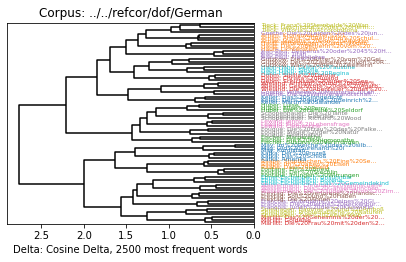

In [6]:
c2500 = lemma_corpus.get_mfw_table(2500)
distances = delta.functions.cosine_delta(c2500)
clustering = delta.Clustering(distances)
delta.Dendrogram(clustering).show()

In [7]:
pd.concat((distances.evaluate(), clustering.fclustering().evaluate()))

F-Ratio                0.364821
Fisher's LD            1.501815
Simple Score           3.829410
Cluster Errors         1.000000
Adjusted Rand Index    0.965961
Homogeneity            0.990683
Completeness           0.992079
V Measure              0.991380
Purity                 0.986667
Entropy                0.009317
dtype: float64

### Deltas and Normalizations

pyDelta provides a number of different delta functions, and it's easy to roll your own. You can list all available delta functions by looking at `delta.functions`. The functions are then available as, e.g., `delta.functions.burrows(corpus)`, and they all return a distance matrix.

In [8]:
delta.functions

Some of the functions (e.g., `euclidean`) are simply wrappers around the corresponding functions of scipy.spatial.distance. So, if you would like to provide the Minkowski norm with $p = \frac{1}{2}$, you can simply create the function using the wrapper class:

In [9]:
delta.MetricDeltaFunction('minkowski', name='l_half', title='Minkowki Norm $L_½$', p=1/2)

While it is possible to implement a delta function from scratch (linear delta is such a case), most “interesting” functions are a _composite_ delta function, i.e. a combination of one or more _normalizations_ and a basis distance function. E.g., Burrows' classic delta works by first normalizing the distance matrix to z-scores and then applying manhatten distance:

In [10]:
delta.functions.burrows

We can also roll our own. E.g., the `ternarize` normalization reduces the z-scores to -1, 0, or 1:
$$
t(z_{i,j}) = \begin{cases}
  -1, & z_{i,j} < -0.43 \\
  \ 0, & -0.43 \le z_{i, j} < 0.43 \\
  +1, & 0.43 < z_{i, j}
\end{cases}
$$
`eder_std` weights each word's influence by rank: $e(w_i) = w_i \frac{n-i}{n}$ for $n$ words, with $w_0$ being the most frequent. We can combine this to ternarized eder:

In [11]:
delta.CompositeDeltaFunction(name='eder_ternarized', descriptor='manhattan-z_score-ternarize-eder_std')

Now we're able to run our analyzis on this:

/home/tv/git/pydelta/delta/graphics.py:89: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(2)


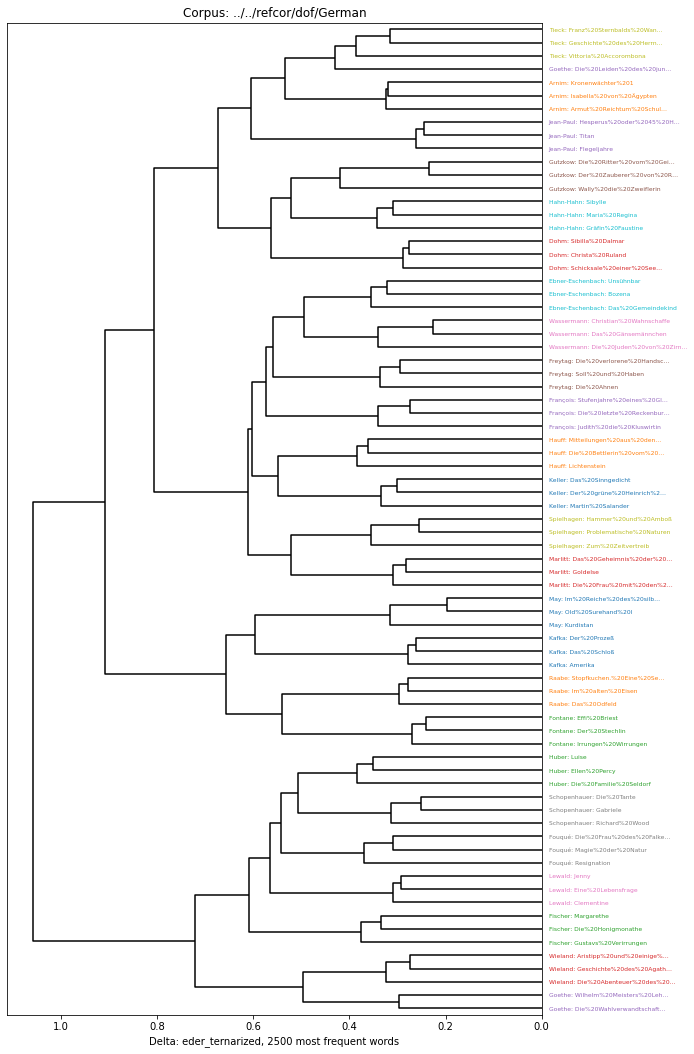

In [12]:
et_clust = delta.Clustering(delta.functions.eder_ternarized(c2500))
plt.figure(figsize=(10,15))
delta.Dendrogram(et_clust).show()

You can also define your own normalizations. E.g., the original z-score normalization has been defined by these few lines:

In [13]:
@delta.normalization(title="Z-Score")
def z_score(corpus):
    """Normalizes the corpus to the z-scores."""
    return (corpus - corpus.mean()) / corpus.std()

Registering z_score (Z-Score) as z_score, replacing existing function with this name
